In [3]:
import os#.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [4]:
import sys
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [5]:
from models_mdf import CustomModel, load_model_, save_model

[2025-05-30 13:11:47,704] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [6]:
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d



class MyLabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self
    
    
def add_spaces(seq):
     return ' '.join(list(seq))
    

def balance_majority(genes: pd.DataFrame, colu, min_count=20, max_count=1500):
    counts = genes[colu].value_counts()
    counts = counts.drop(counts[min_count>counts].index)
    resampled = pd.DataFrame()
    maj_clss = (counts[counts>max_count]).index
    left_genes = pd.DataFrame()
    mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
    for cl in mean_clss:
        #print(cl)
        left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])
    for maj_cl in maj_clss:        
        resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
    return pd.concat([left_genes, resampled])

In [7]:
vdjdb = pd.read_csv('../data/vdjdb_full.txt', sep='\t', low_memory=False)
vdjdb = vdjdb[vdjdb['antigen.epitope'] != 'KLGGALQAK']

In [8]:
vdjdb.columns


Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope',
       'antigen.gene', 'antigen.species', 'reference.id',
       'method.identification', 'method.frequency', 'method.singlecell',
       'method.sequencing', 'method.verification', 'meta.study.id',
       'meta.cell.subset', 'meta.subject.cohort', 'meta.subject.id',
       'meta.replica.id', 'meta.clone.id', 'meta.epitope.id', 'meta.tissue',
       'meta.donor.MHC', 'meta.donor.MHC.method', 'meta.structure.id',
       'cdr3fix.alpha', 'cdr3fix.beta', 'vdjdb.score'],
      dtype='object')

In [9]:
vdjb_short = vdjdb[['cdr3.alpha', 'cdr3.beta', 'antigen.epitope', 'antigen.species', 'species']]
# vdjb_short2 = vdjdb[['cdr3.alpha', 'cdr3.beta', 'antigen.epitope', 'species']]

In [10]:
le = MyLabelEncoder()
groups = vdjb_short['antigen.epitope'].value_counts().index

le.fit(groups)

MyLabelEncoder()

In [11]:
vdjb_short['antigen.epitope']= le.transform(vdjb_short['antigen.epitope'])
vdjb_short

/scratch/ipykernel_114272/468457691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjb_short['antigen.epitope']= le.transform(vdjb_short['antigen.epitope'])


cdr3.alpha             cdr3.beta  antigen.epitope antigen.species  \
0       CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF               37           HIV-1   
1                 NaN   CASSFEAGQGFFSNQPQHF               37           HIV-1   
2      CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF               37           HIV-1   
3         CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF               37           HIV-1   
4       CAYRPPGTYKYIF        CASSALASLNEQFF               37           HIV-1   
...               ...                   ...              ...             ...   
62172   CMDEGGSNYKLTF         CASSVRSTDTQYF              131           Wheat   
62173     CSLYNNNDMRF         CASSLRYTDTQYF              131           Wheat   
62174   CALSTDSWGKLQF       CASSPGQGGDNEQFF              244           Wheat   
62175    CAPQGATNKLIF       CASSLGAGGQETQYF              244           Wheat   
62176  CLVGGSGGYNKLIF         CASSSTAQETQYF              244           Wheat   

           species  
0      HomoSapiens  
1      HomoSapiens  
2      HomoSapiens  
3      HomoSapiens  
4      HomoSapiens  
...            ...  
62172  HomoSapiens  
62173  HomoSapiens  
62174  HomoSapiens  
62175  HomoSapiens  
62176  HomoSapiens  

[48203 rows x 5 columns]

In [19]:
vdjb_short = vdjb_short[vdjb_short['antigen.epitope']<=18]

In [20]:
vdjb_short = vdjb_short.fillna('')
vdjb_short['cdr3aa'] = vdjb_short['cdr3.alpha'] + vdjb_short['cdr3.beta'].apply(lambda s: s[::-1])

In [21]:
vdjb_cdr = vdjb_short[['cdr3aa', 'antigen.epitope', 'antigen.species', 'species']]

In [22]:
vdjb_cdr.dropna(inplace=True)
# vdjb_cdr.reset_index(inplace=True, drop=True)

/scratch/ipykernel_3475771/2086238376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjb_cdr.dropna(inplace=True)


In [23]:
vdjb_cdr = balance_majority(vdjb_cdr, 'antigen.epitope', max_count=500)

In [24]:
vdjb_cdr

cdr3aa  antigen.epitope antigen.species  \
13267                 CAMREGIEGYSTLTF                0      InfluenzaA   
19416                   FYQTDLSVTSSAC                0      InfluenzaA   
14717                   FYQTDSGLSSSAC                0      InfluenzaA   
13802                  CLVGDIRGNNRLAF                0      InfluenzaA   
23444  CALSEVQLMDSNYQLIWFHQPQGSYISSAC                0      InfluenzaA   
...                               ...              ...             ...   
18310   CALSGLGYGNKLVFFFAETGGRGLGTSAC               18      InfluenzaA   
52484                 FTYGMPEGQLLSSAC               18      InfluenzaA   
18258  CAENMRGSNYKLTFFFAETNSQRGDLSSAC               18      InfluenzaA   
52610                  FYQTDVAGGGNSAC               18      InfluenzaA   
18246                  FYITNGNDTYSSAC               18      InfluenzaA   

           species  
13267  HomoSapiens  
19416  HomoSapiens  
14717  HomoSapiens  
13802  HomoSapiens  
23444  HomoSapiens  
...            ...  
18310  HomoSapiens  
52484  HomoSapiens  
18258  HomoSapiens  
52610  HomoSapiens  
18246  HomoSapiens  

[9500 rows x 4 columns]

In [25]:
test_dataset = vdjb_cdr.sample(frac=0.15, random_state=42)
vdjb_cdr_train = vdjb_cdr.drop(test_dataset.index)

In [26]:
vdjb_cdr_train['cdr3aa'] = vdjb_cdr_train['cdr3aa'].apply(add_spaces)
test_dataset['cdr3aa'] = test_dataset['cdr3aa'].apply(add_spaces)

In [27]:
vdjb_cdr_train = vdjb_cdr_train.reset_index(drop=True)
vdjb_cdr_train

cdr3aa  antigen.epitope  \
0                             F Y Q T D L S V T S S A C                0   
1                             F Y Q T D S G L S S S A C                0   
2     C A L S E V Q L M D S N Y Q L I W F H Q P Q G ...                0   
3                             F Y Q T D T S R E S S A C                0   
4     C A V P L T G G G N K L T F F Y Q E Y S S R I ...                0   
...                                                 ...              ...   
8070  C A L S E A G A G S Y Q L T F F F A E T N G Q ...               18   
8071  C A L S G L G Y G N K L V F F F A E T G G R G ...               18   
8072                      F T Y G M P E G Q L L S S A C               18   
8073  C A E N M R G S N Y K L T F F F A E T N S Q R ...               18   
8074                        F Y I T N G N D T Y S S A C               18   

     antigen.species      species  
0         InfluenzaA  HomoSapiens  
1         InfluenzaA  HomoSapiens  
2         InfluenzaA  HomoSapiens  
3         InfluenzaA  HomoSapiens  
4         InfluenzaA  HomoSapiens  
...              ...          ...  
8070      InfluenzaA  HomoSapiens  
8071      InfluenzaA  HomoSapiens  
8072      InfluenzaA  HomoSapiens  
8073      InfluenzaA  HomoSapiens  
8074      InfluenzaA  HomoSapiens  

[8075 rows x 4 columns]

In [28]:
vdjb_cdr_train['antigen.epitope'].nunique()

19

In [29]:
epit_model = load_model_('models_ft/tcr_epit.pth', mod_type='TCR-bert', num_labels=19)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [30]:
print(epit_model.n_labels)#to(device)

19


In [31]:
# ans

In [32]:
epit_model.maximun_len = 45
epit_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [35]:
ans = test_dataset['antigen.epitope']
test_dataset = test_dataset.drop(columns=['antigen.epitope'])

pred_labels = epit_model.predict(test_dataset['cdr3aa'])
f1_sc_tcr = f1_score(ans, pred_labels, average='weighted')
print('Total f1_score: %.5f' % f1_sc_tcr)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.76940


In [36]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [39]:
vis_vdjb_cdr = vdjb_cdr_train.sample(frac=0.5, random_state=42)[['cdr3aa', 'antigen.epitope', 'species']]

hidden_states_mean = []
hidden_states_pooled = []
labels = []
species = []


epit_model.model.eval()
epit_model.model.to(device)

for i in tqdm(vis_vdjb_cdr.index):
    seq, lab, sp = vis_vdjb_cdr.loc[i]
    encoding = epit_model.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=epit_model.maximun_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = epit_model.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    species.append(sp)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 4038/4038 [00:43<00:00, 91.91it/s]


In [40]:
mapping = dict(zip(set(species), range(len(set(species)))))
mapping

{'MusMusculus': 0, 'MacacaMulatta': 1, 'HomoSapiens': 2}

### By species

In [41]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=0.9)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(pca_embedding)//3),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1500,
    metric='cosine',
    init='pca',
    random_state=42,
    n_jobs=-1,
    verbose=0)
tsne_results = tsne.fit_transform(pca_embedding)



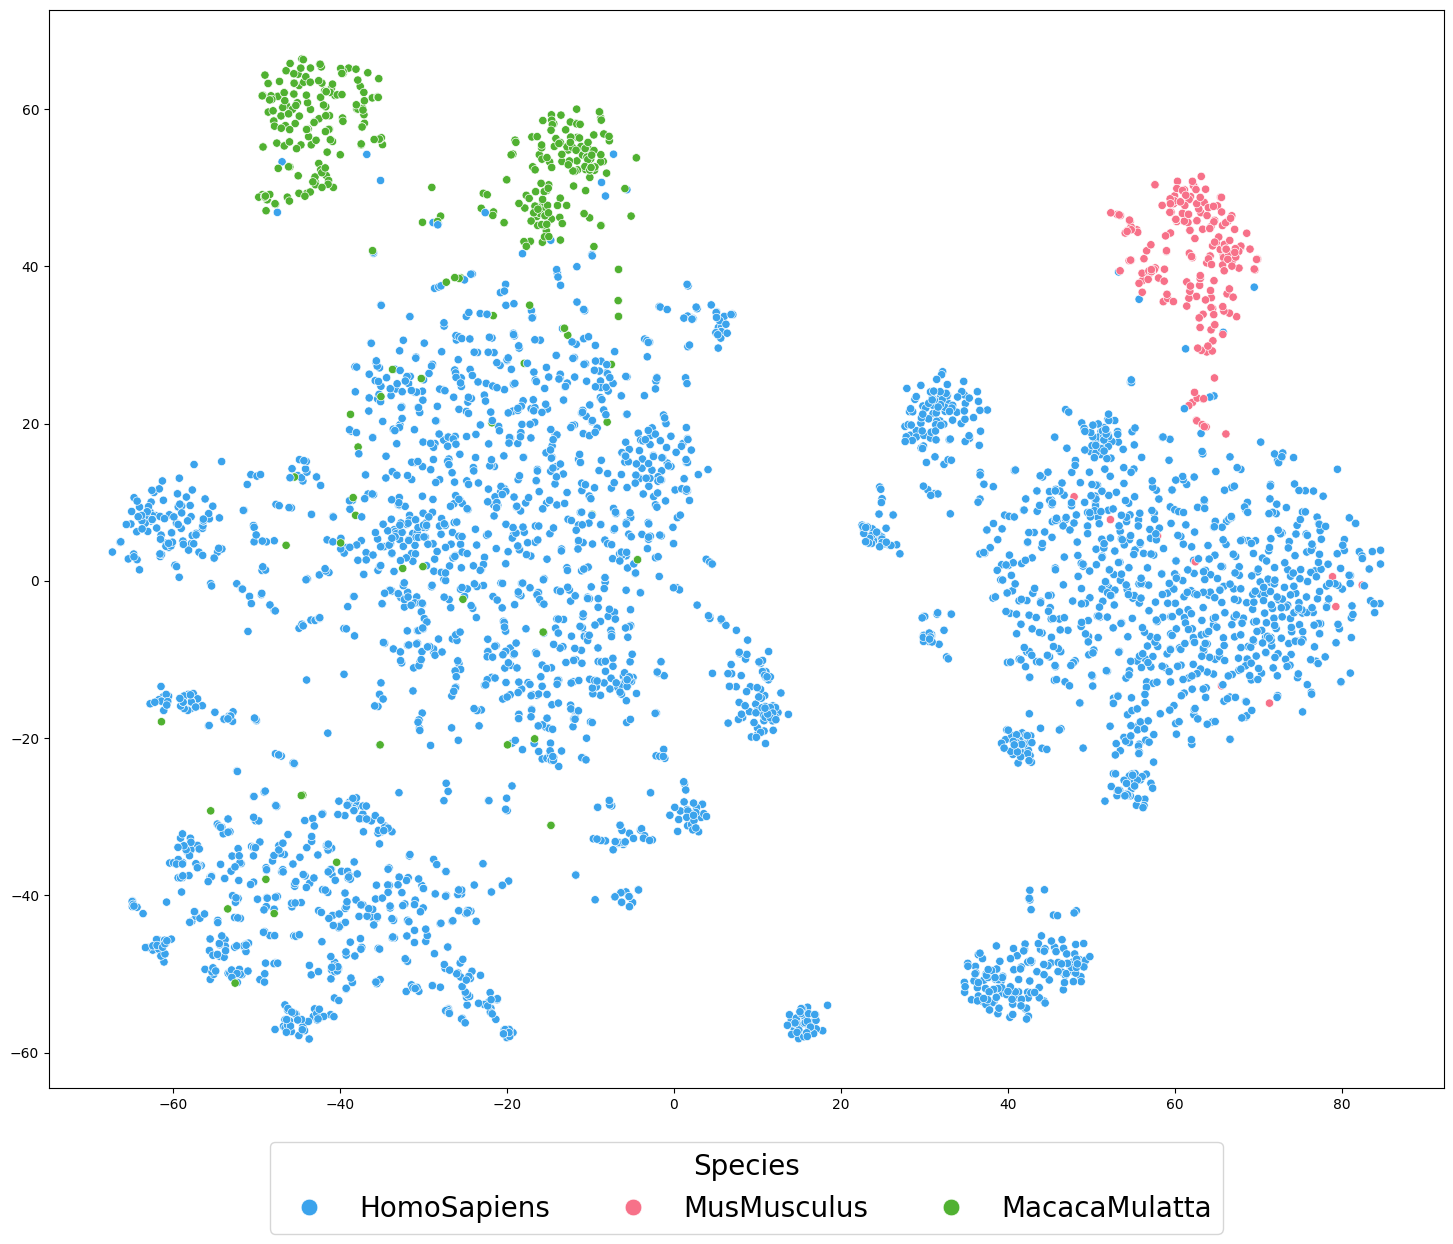

In [51]:
unique_labels = mapping.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping.keys()))
color_map = dict(zip(mapping.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=species,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='Species',
    title_fontsize=20,
    markerscale=2,
    ncols=4
)

# plt.savefig('../imgs/epitopes/All_chain.png')

In [52]:
# by ag species

In [53]:
vis_vdjb_cdr = vdjb_cdr_train.sample(frac=0.5, random_state=42)[['cdr3aa', 'antigen.epitope', 'antigen.species']]

hidden_states_mean = []
hidden_states_pooled = []
labels = []
species = []


epit_model.model.eval()
epit_model.model.to(device)

for i in tqdm(vis_vdjb_cdr.index):
    seq, lab, sp = vis_vdjb_cdr.loc[i]
    encoding = epit_model.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=epit_model.maximun_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = epit_model.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    species.append(sp)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 4038/4038 [00:43<00:00, 93.33it/s]


In [54]:
mapping = dict(zip(set(species), range(len(set(species)))))
mapping

{'SIV': 0,
 'HomoSapiens': 1,
 'HIV-1': 2,
 'EBV': 3,
 'YFV': 4,
 'CMV': 5,
 'SARS-CoV-2': 6,
 'InfluenzaA': 7}

In [55]:
pca = PCA(n_components=0.9)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(pca_embedding)//3),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1500,
    metric='cosine',
    init='pca',
    random_state=42,
    n_jobs=-1,
    verbose=0)
tsne_results = tsne.fit_transform(pca_embedding)



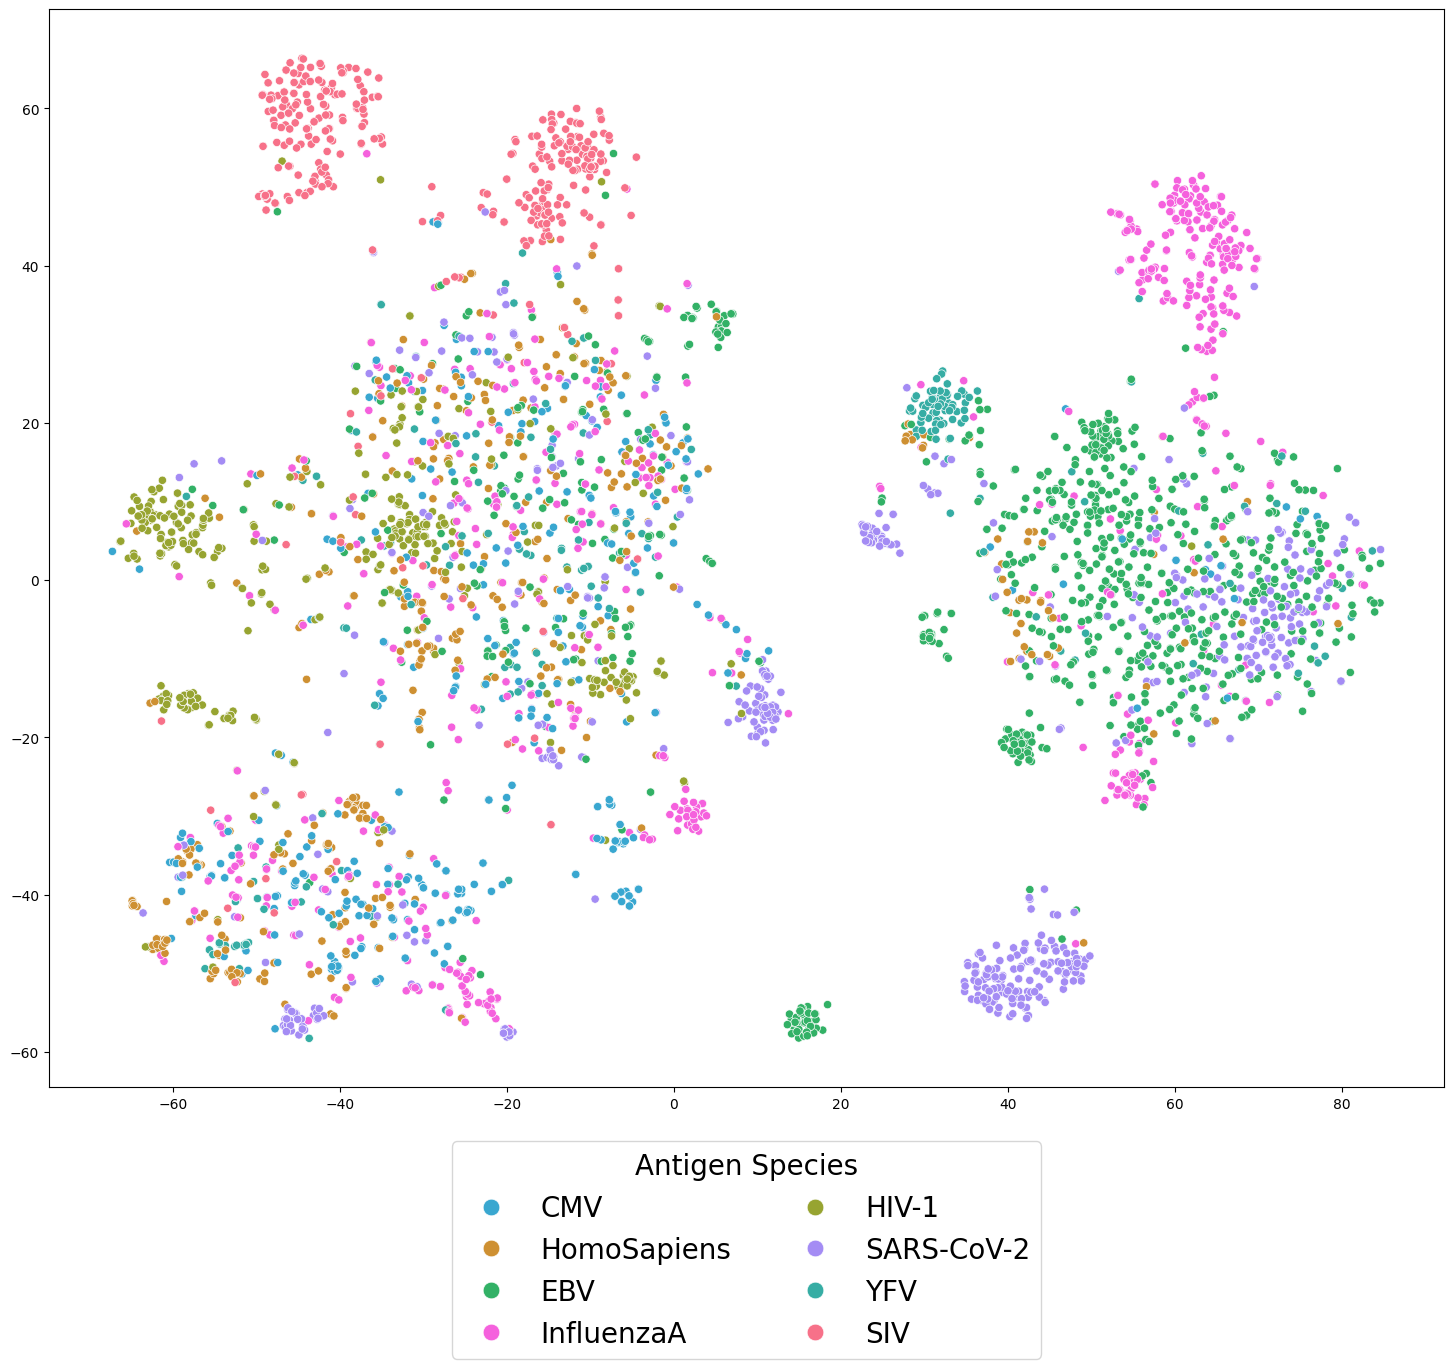

In [57]:
unique_labels = mapping.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping.keys()))
color_map = dict(zip(mapping.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=species,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='Antigen Species',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

plt.savefig('../imgs/epitopes/AG_species.png')

In [58]:
homo = vdjb_cdr_train[vdjb_cdr_train['species']=='HomoSapiens']

In [59]:
homo.drop(columns='species', inplace=True)

/scratch/ipykernel_3475771/1703765384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homo.drop(columns='species', inplace=True)


In [60]:
vis_vdjb_cdr = homo.sample(frac=0.5, random_state=42)#[['cdr3aa', 'antigen.epitope', 'antigen.species']]

hidden_states_mean = []
hidden_states_pooled = []
labels = []
species = []


epit_model.model.eval()
epit_model.model.to(device)

for i in tqdm(vis_vdjb_cdr.index):
    seq, lab, sp = vis_vdjb_cdr.loc[i]
    encoding = epit_model.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=epit_model.maximun_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = epit_model.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    species.append(sp)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 3404/3404 [00:36<00:00, 92.14it/s]


In [61]:
mapping = dict(zip(set(species), range(len(set(species)))))
mapping

{'HomoSapiens': 0,
 'HIV-1': 1,
 'EBV': 2,
 'YFV': 3,
 'CMV': 4,
 'SARS-CoV-2': 5,
 'InfluenzaA': 6}

In [63]:
pca = PCA(n_components=0.9)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(pca_embedding)//3),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1500,
    metric='cosine',
    init='pca',
    random_state=42,
    n_jobs=-1,
    verbose=0)
tsne_results = tsne.fit_transform(pca_embedding)



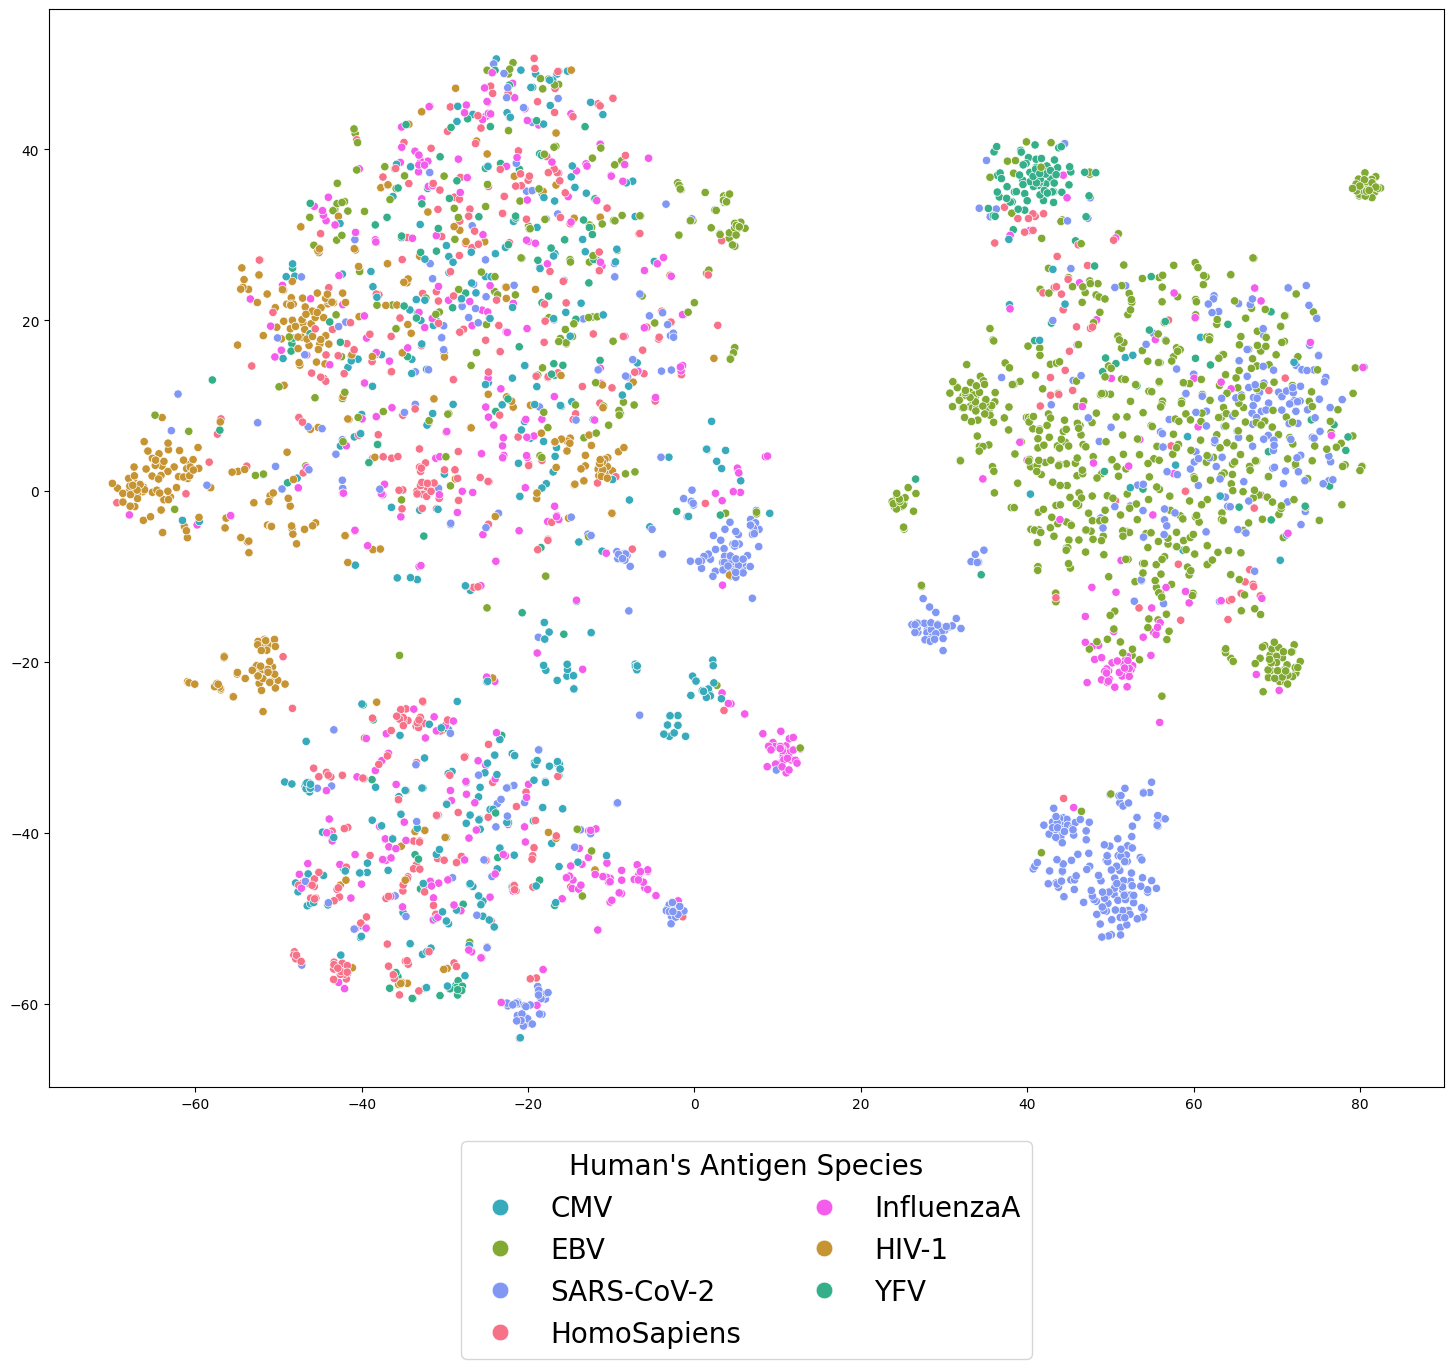

In [65]:
unique_labels = mapping.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping.keys()))
color_map = dict(zip(mapping.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=species,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='Human\'s Antigen Species',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

plt.savefig('../imgs/epitopes/Homo_AG_species.png')

### By MHC

In [24]:
vdjdb_mhc = vdjdb[['cdr3.alpha', 'antigen.species', 'cdr3.beta', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope']]

In [25]:
vdjdb_mhc

cdr3.alpha antigen.species             cdr3.beta           mhc.a  \
0       CIVRAPGRADMRF           HIV-1  CASSYLPGQGDHYSNQPQHF        HLA-B*08   
1                 NaN           HIV-1   CASSFEAGQGFFSNQPQHF        HLA-B*08   
2      CAVPSGAGSYQLTF           HIV-1   CASSFEPGQGFYSNQPQHF        HLA-B*08   
3         CAVKASGSRLT           HIV-1  CASSYEPGQVSHYSNQPQHF        HLA-B*08   
4       CAYRPPGTYKYIF           HIV-1        CASSALASLNEQFF        HLA-B*08   
...               ...             ...                   ...             ...   
62172   CMDEGGSNYKLTF           Wheat         CASSVRSTDTQYF  HLA-DQA1*05:01   
62173     CSLYNNNDMRF           Wheat         CASSLRYTDTQYF  HLA-DQA1*05:01   
62174   CALSTDSWGKLQF           Wheat       CASSPGQGGDNEQFF  HLA-DQA1*05:01   
62175    CAPQGATNKLIF           Wheat       CASSLGAGGQETQYF  HLA-DQA1*05:01   
62176  CLVGGSGGYNKLIF           Wheat         CASSSTAQETQYF  HLA-DQA1*05:01   

                mhc.b mhc.class antigen.epitope  
0                 B2M      MHCI        FLKEKGGL  
1                 B2M      MHCI        FLKEKGGL  
2                 B2M      MHCI        FLKEKGGL  
3                 B2M      MHCI        FLKEKGGL  
4                 B2M      MHCI        FLKEKGGL  
...               ...       ...             ...  
62172  HLA-DQB1*02:01     MHCII    PQPELPYPQPQL  
62173  HLA-DQB1*02:01     MHCII    PQPELPYPQPQL  
62174  HLA-DQB1*02:01     MHCII   PQQPFPQPEQPFP  
62175  HLA-DQB1*02:01     MHCII   PQQPFPQPEQPFP  
62176  HLA-DQB1*02:01     MHCII   PQQPFPQPEQPFP  

[48203 rows x 7 columns]

In [26]:
def process_types(string, typ = 'A'):
    
    # pattern = r'[A-Za-z]+[-\dA-Za-z]*\d*'
    # res = re.search(pattern, string)[0]
    return string.split(':')[0]

In [27]:
vdjdb_mhc['mhc.a'] = vdjdb_mhc['mhc.a'].apply(process_types)
vdjdb_mhc['mhc.b'] = vdjdb_mhc['mhc.b'].apply(process_types)

/scratch/ipykernel_114272/571099007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjdb_mhc['mhc.a'] = vdjdb_mhc['mhc.a'].apply(process_types)
/scratch/ipykernel_114272/571099007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjdb_mhc['mhc.b'] = vdjdb_mhc['mhc.b'].apply(process_types)


In [28]:
vdjdb_mhc

cdr3.alpha antigen.species             cdr3.beta        mhc.a  \
0       CIVRAPGRADMRF           HIV-1  CASSYLPGQGDHYSNQPQHF     HLA-B*08   
1                 NaN           HIV-1   CASSFEAGQGFFSNQPQHF     HLA-B*08   
2      CAVPSGAGSYQLTF           HIV-1   CASSFEPGQGFYSNQPQHF     HLA-B*08   
3         CAVKASGSRLT           HIV-1  CASSYEPGQVSHYSNQPQHF     HLA-B*08   
4       CAYRPPGTYKYIF           HIV-1        CASSALASLNEQFF     HLA-B*08   
...               ...             ...                   ...          ...   
62172   CMDEGGSNYKLTF           Wheat         CASSVRSTDTQYF  HLA-DQA1*05   
62173     CSLYNNNDMRF           Wheat         CASSLRYTDTQYF  HLA-DQA1*05   
62174   CALSTDSWGKLQF           Wheat       CASSPGQGGDNEQFF  HLA-DQA1*05   
62175    CAPQGATNKLIF           Wheat       CASSLGAGGQETQYF  HLA-DQA1*05   
62176  CLVGGSGGYNKLIF           Wheat         CASSSTAQETQYF  HLA-DQA1*05   

             mhc.b mhc.class antigen.epitope  
0              B2M      MHCI        FLKEKGGL  
1              B2M      MHCI        FLKEKGGL  
2              B2M      MHCI        FLKEKGGL  
3              B2M      MHCI        FLKEKGGL  
4              B2M      MHCI        FLKEKGGL  
...            ...       ...             ...  
62172  HLA-DQB1*02     MHCII    PQPELPYPQPQL  
62173  HLA-DQB1*02     MHCII    PQPELPYPQPQL  
62174  HLA-DQB1*02     MHCII   PQQPFPQPEQPFP  
62175  HLA-DQB1*02     MHCII   PQQPFPQPEQPFP  
62176  HLA-DQB1*02     MHCII   PQQPFPQPEQPFP  

[48203 rows x 7 columns]

In [29]:
le = MyLabelEncoder()
groups = vdjdb_mhc['antigen.epitope'].value_counts().index

le.fit(groups)

MyLabelEncoder()

In [30]:
vdjdb_mhc['antigen.epitope']= le.transform(vdjdb_mhc['antigen.epitope'])
vdjdb_mhc

/scratch/ipykernel_114272/2593487640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjdb_mhc['antigen.epitope']= le.transform(vdjdb_mhc['antigen.epitope'])


cdr3.alpha antigen.species             cdr3.beta        mhc.a  \
0       CIVRAPGRADMRF           HIV-1  CASSYLPGQGDHYSNQPQHF     HLA-B*08   
1                 NaN           HIV-1   CASSFEAGQGFFSNQPQHF     HLA-B*08   
2      CAVPSGAGSYQLTF           HIV-1   CASSFEPGQGFYSNQPQHF     HLA-B*08   
3         CAVKASGSRLT           HIV-1  CASSYEPGQVSHYSNQPQHF     HLA-B*08   
4       CAYRPPGTYKYIF           HIV-1        CASSALASLNEQFF     HLA-B*08   
...               ...             ...                   ...          ...   
62172   CMDEGGSNYKLTF           Wheat         CASSVRSTDTQYF  HLA-DQA1*05   
62173     CSLYNNNDMRF           Wheat         CASSLRYTDTQYF  HLA-DQA1*05   
62174   CALSTDSWGKLQF           Wheat       CASSPGQGGDNEQFF  HLA-DQA1*05   
62175    CAPQGATNKLIF           Wheat       CASSLGAGGQETQYF  HLA-DQA1*05   
62176  CLVGGSGGYNKLIF           Wheat         CASSSTAQETQYF  HLA-DQA1*05   

             mhc.b mhc.class  antigen.epitope  
0              B2M      MHCI               37  
1              B2M      MHCI               37  
2              B2M      MHCI               37  
3              B2M      MHCI               37  
4              B2M      MHCI               37  
...            ...       ...              ...  
62172  HLA-DQB1*02     MHCII              131  
62173  HLA-DQB1*02     MHCII              131  
62174  HLA-DQB1*02     MHCII              244  
62175  HLA-DQB1*02     MHCII              244  
62176  HLA-DQB1*02     MHCII              244  

[48203 rows x 7 columns]

In [32]:
vdjdb_mhc = vdjdb_mhc[vdjdb_mhc['antigen.epitope']<=18]

In [33]:
vdjdb_mhc['mhc.a'].unique()

array(['HLA-A*02', 'HLA-B*27', 'HLA-DRA*01', 'HLA-B*44', 'HLA-B*08',
       'HLA-A*11', 'HLA-DPA*01', 'H-2Kb', 'HLA-B*07', 'Mamu-A*01'],
      dtype=object)

In [34]:
vdjdb_mhc = vdjdb_mhc.fillna('')
vdjdb_mhc['cdr3aa'] = vdjdb_mhc['cdr3.alpha'] + vdjdb_mhc['cdr3.beta'].apply(lambda s: s[::-1])

In [35]:
vdjb_mhc_cdr = vdjdb_mhc[['cdr3aa',  'antigen.species', 'antigen.epitope', 'mhc.a', 'mhc.b', 'mhc.class']]

In [36]:
vdjb_mhc_cdr.dropna(inplace=True)
# vdjb_cdr.reset_index(inplace=True, drop=True)

/scratch/ipykernel_114272/2763688121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdjb_mhc_cdr.dropna(inplace=True)


In [37]:
vdjb_mhc_cdr = balance_majority(vdjb_mhc_cdr, 'antigen.epitope', max_count=500)

In [38]:
test_dataset = vdjb_mhc_cdr.sample(frac=0.10, random_state=42)
vdjb_cdr_train = vdjb_mhc_cdr.drop(test_dataset.index)

In [39]:
vdjb_cdr_train['cdr3aa'] = vdjb_cdr_train['cdr3aa'].apply(add_spaces)
test_dataset['cdr3aa'] = test_dataset['cdr3aa'].apply(add_spaces)

In [40]:
vdjb_cdr_train = vdjb_cdr_train.reset_index(drop=True)
vdjb_cdr_train

cdr3aa antigen.species  \
0                             F Y Q T D L S V T S S A C      InfluenzaA   
1                             F Y Q T D S G L S S S A C      InfluenzaA   
2     C A L S E V Q L M D S N Y Q L I W F H Q P Q G ...      InfluenzaA   
3                             F Y Q T D T S R E S S A C      InfluenzaA   
4     C A V P L T G G G N K L T F F Y Q E Y S S R I ...      InfluenzaA   
...                                                 ...             ...   
8545  C A L S G L G Y G N K L V F F F A E T G G R G ...      InfluenzaA   
8546                      F T Y G M P E G Q L L S S A C      InfluenzaA   
8547  C A E N M R G S N Y K L T F F F A E T N S Q R ...      InfluenzaA   
8548                        F Y Q T D V A G G G N S A C      InfluenzaA   
8549                        F Y I T N G N D T Y S S A C      InfluenzaA   

      antigen.epitope       mhc.a        mhc.b mhc.class  
0                   0    HLA-A*02          B2M      MHCI  
1                   0    HLA-A*02          B2M      MHCI  
2                   0    HLA-A*02          B2M      MHCI  
3                   0    HLA-A*02          B2M      MHCI  
4                   0    HLA-A*02          B2M      MHCI  
...               ...         ...          ...       ...  
8545               18  HLA-DRA*01  HLA-DRB1*04     MHCII  
8546               18  HLA-DRA*01  HLA-DRB1*01     MHCII  
8547               18  HLA-DRA*01  HLA-DRB1*04     MHCII  
8548               18  HLA-DRA*01  HLA-DRB1*01     MHCII  
8549               18  HLA-DRA*01  HLA-DRB1*04     MHCII  

[8550 rows x 6 columns]

In [41]:
vdjb_cdr_train['antigen.epitope'].nunique()

19

In [42]:
epit_model = load_model_('models_ft/tcr_epit.pth', mod_type='TCR-bert', num_labels=19)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [43]:
print(epit_model.n_labels)#to(device)

19


In [44]:
# ans

In [45]:
epit_model.maximun_len = 45
epit_model.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [46]:
ans = test_dataset['antigen.epitope']
test_dataset = test_dataset.drop(columns=['antigen.epitope'])

pred_labels = epit_model.predict(test_dataset['cdr3aa'])
f1_sc_tcr = f1_score(ans, pred_labels, average='weighted')
print('Total f1_score: %.5f' % f1_sc_tcr)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.78302


In [47]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [48]:
vis_vdjb_cdr = vdjb_cdr_train.sample(frac=0.5, random_state=42)[['cdr3aa',  'antigen.species', 'antigen.epitope', 'mhc.a', 'mhc.b', 'mhc.class']]

hidden_states_mean = []
hidden_states_pooled = []
labels = []
species = []
mhc_alpha = []
mhc_beta = []
mhc_class = []

epit_model.model.eval()
epit_model.model.to(device)

for i in tqdm(vis_vdjb_cdr.index):
    seq, sp, lab, mhc_a, mhc_b, mhc_cl = vis_vdjb_cdr.loc[i]
    encoding = epit_model.tokenizer.encode_plus(
        seq,
        add_special_tokens=True,
        max_length=epit_model.maximun_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = epit_model.model(
            input_ids, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
    
    layer_means = [hidden_state.mean().item() 
                  for hidden_state in outputs.hidden_states]
    hidden_states_mean.append(layer_means)
    
    labels.append(lab)
    species.append(sp)
    mhc_alpha.append(mhc_a)
    mhc_beta.append(mhc_b)
    mhc_class.append(mhc_cl)
    
    last_n_layers = torch.stack(outputs.hidden_states[-4:]) 
    pooled_embedding = last_n_layers.mean(dim=(0, 2, 1))  
    hidden_states_pooled.append(pooled_embedding.tolist())


100%|██████████| 4275/4275 [00:48<00:00, 89.05it/s]


In [49]:
mapping_a = dict(zip(set(mhc_alpha), range(len(set(mhc_alpha)))))
mapping_b = dict(zip(set(mhc_beta), range(len(set(mhc_beta)))))
mapping_c = dict(zip(set(mhc_class), range(len(set(mhc_class)))))
mappind_species = dict(zip(set(species), range(len(set(species)))))

In [51]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=0.9)
pca_embedding = pca.fit_transform(hidden_states_pooled)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, len(pca_embedding)//3),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=1500,
    metric='cosine',
    init='pca',
    random_state=42,
    n_jobs=-1,
    verbose=0)
tsne_results = tsne.fit_transform(pca_embedding)



In [60]:
mapping_all = [mappind_species,  mapping_a, mapping_c, mapping_b]
h = [species,  mhc_alpha, mhc_class, mhc_beta]
label_plot = ['Antigen species',  'MHC A', 'MHC class', 'MHC B']

In [61]:
palettes = ['husl',  'Set2', 'gnuplot','tab20']


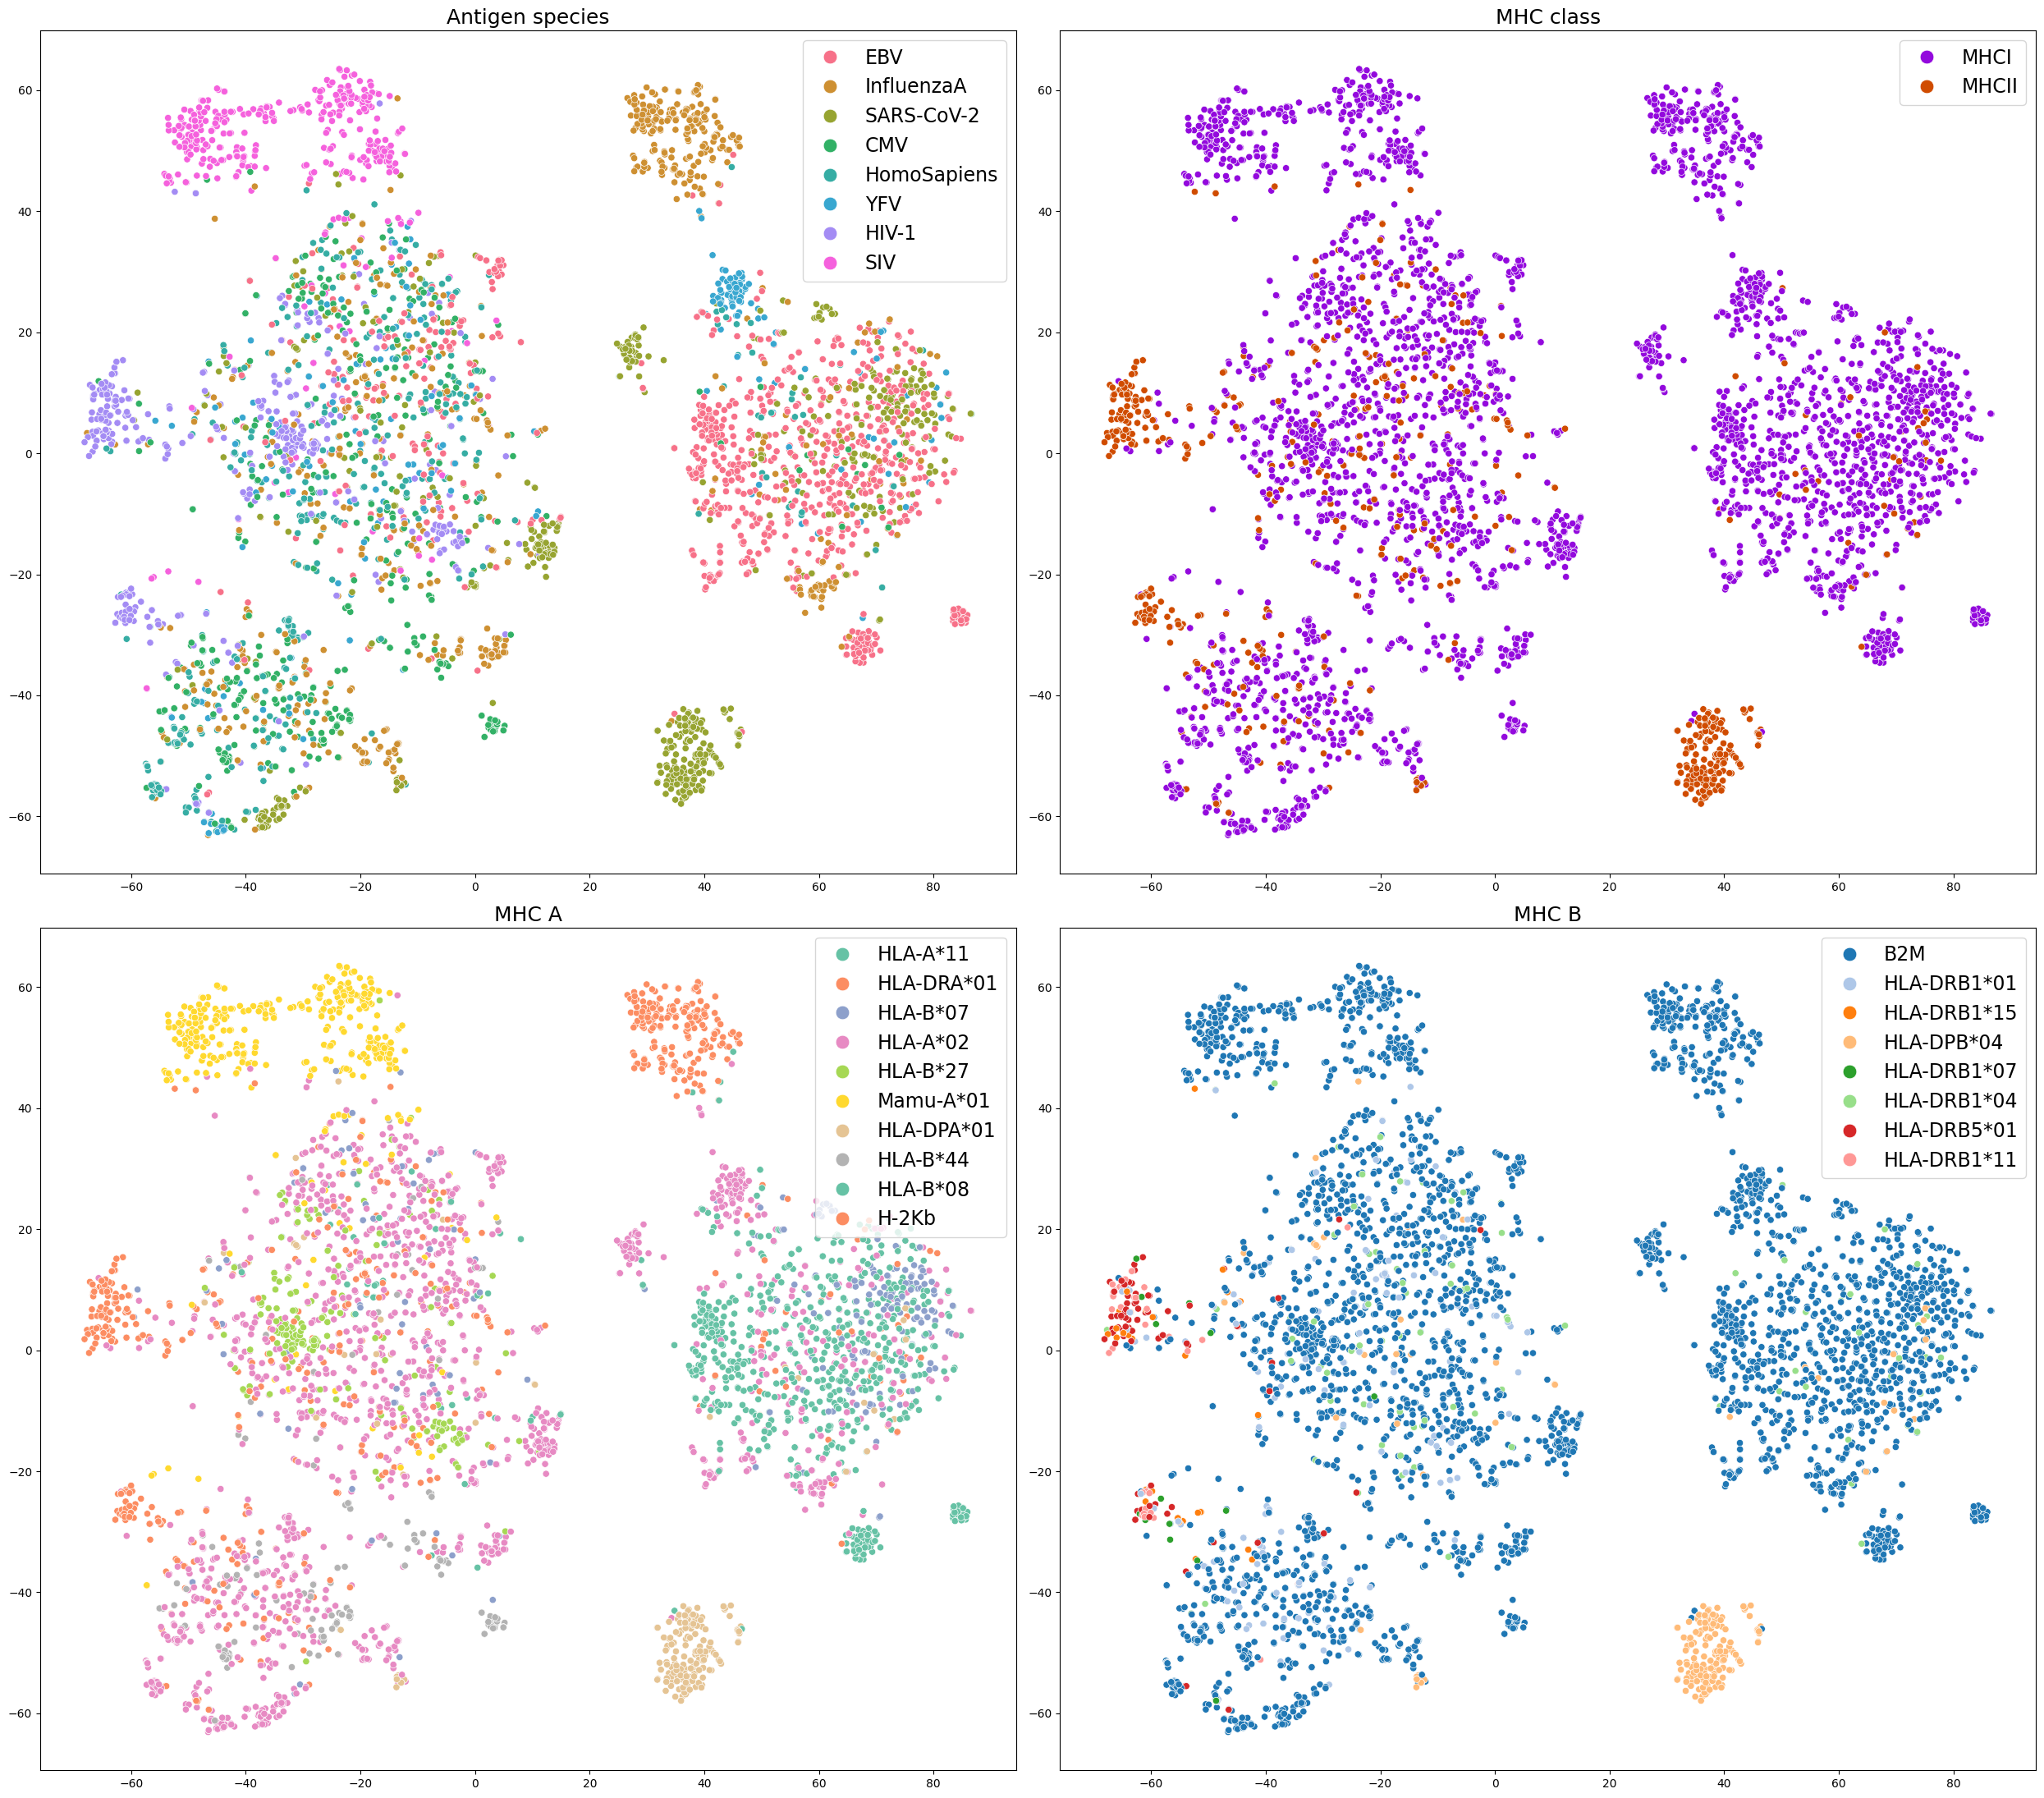

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(25, 22))

for i in range(len(mapping_all)):
    mapp = mapping_all[i]
    # unique_labels = mapp.keys()#np.unique(le.inverse_transform(labels))
    # palette = sns.color_palette("husl", n_colors=len(mapp.keys()))
    # color_map = dict(zip(mapp.keys(), palette))
    titl = label_plot[i]
    # colors = [color_map[label] for label in h[i]]

    
    ax1 = 0 if (i == 0 or i == 2) else 1
    ax2 = 0 if i<2 else 1
    
    ax = axes[ax1, ax2]
    
    sns.scatterplot(
        x=tsne_results[:,0],
        y=tsne_results[:,1],
        hue=h[i],
        palette=palettes[i],#"husl",
        ax=ax,
        # legend="full",
        alpha=1)
    
    ax.set_title(titl, fontsize=18)
    ax.legend(fontsize=17, markerscale=2)#, bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()

In [ ]:
unique_labels = mappind_species.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping_a.keys()))
color_map = dict(zip(mapping_a.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=mhc_alpha,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='MHC A',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

plt.savefig('../imgs/epitopes/AG_species.png')

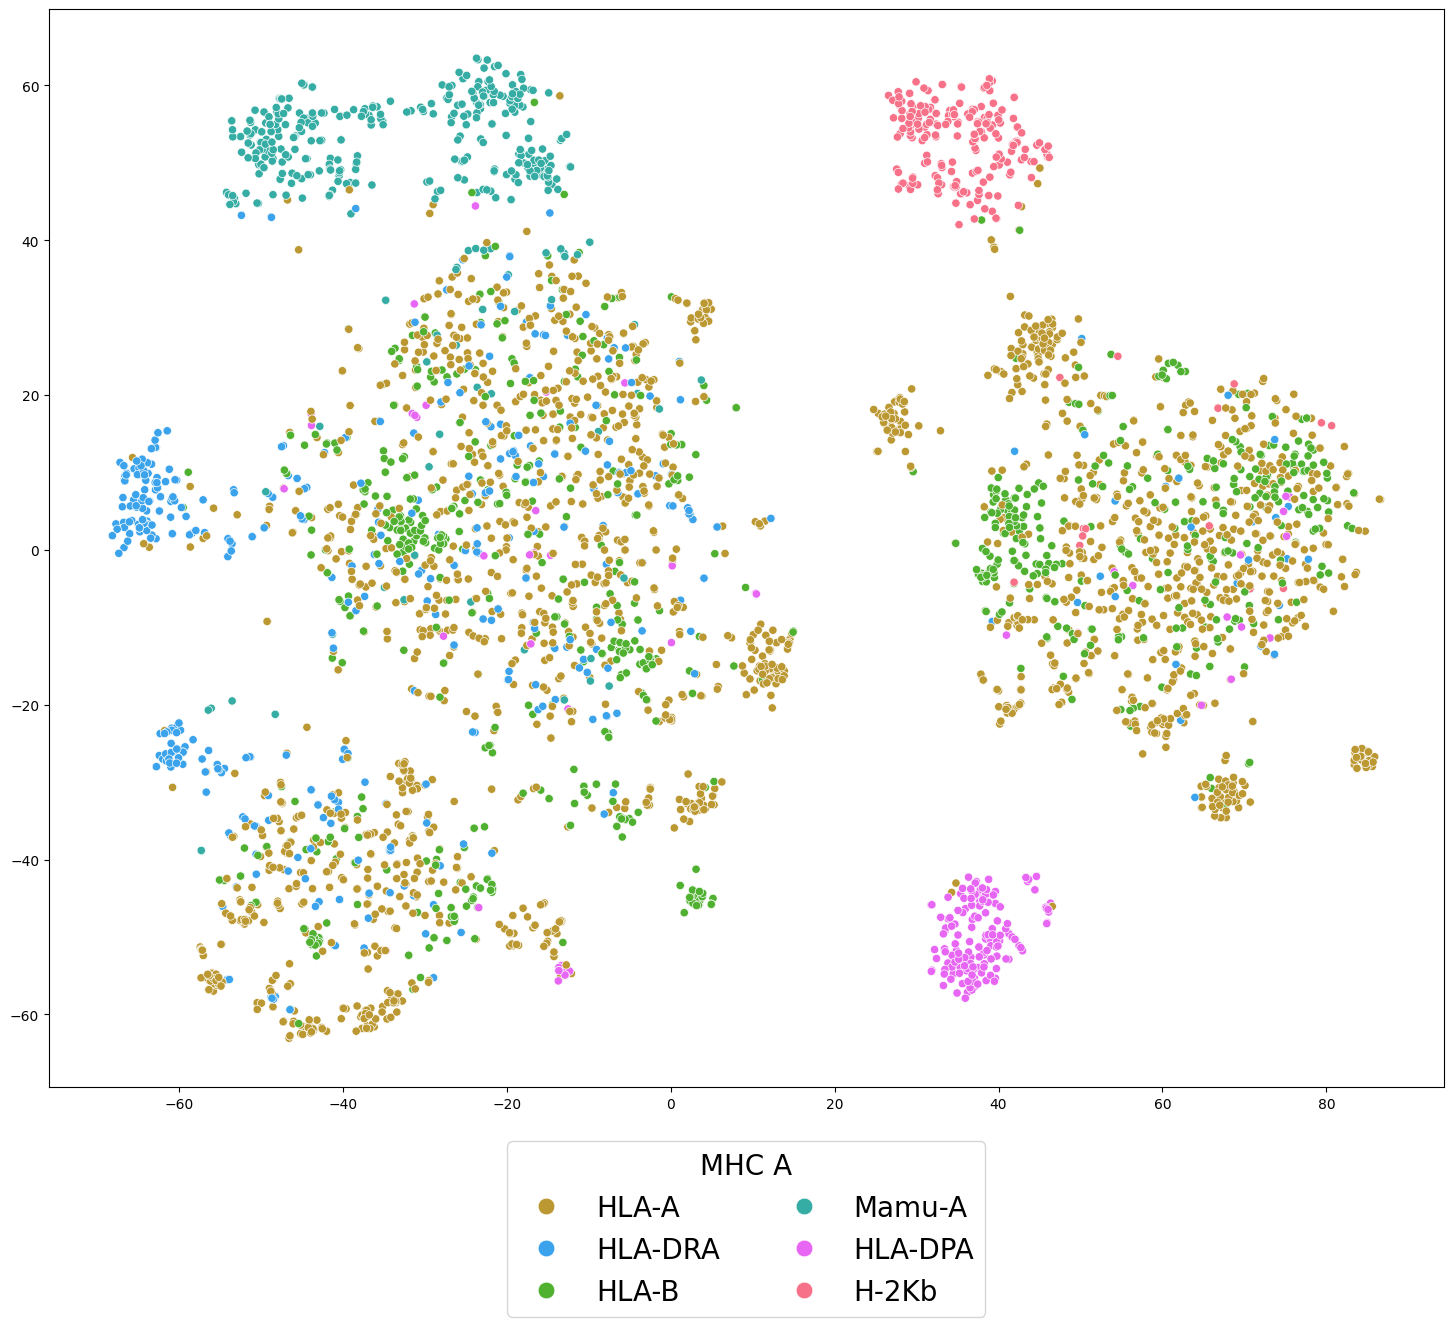

In [96]:
unique_labels = mapping_a.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping_a.keys()))
color_map = dict(zip(mapping_a.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=mhc_alpha,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='MHC A',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

plt.savefig('../imgs/epitopes/AG_species.png')

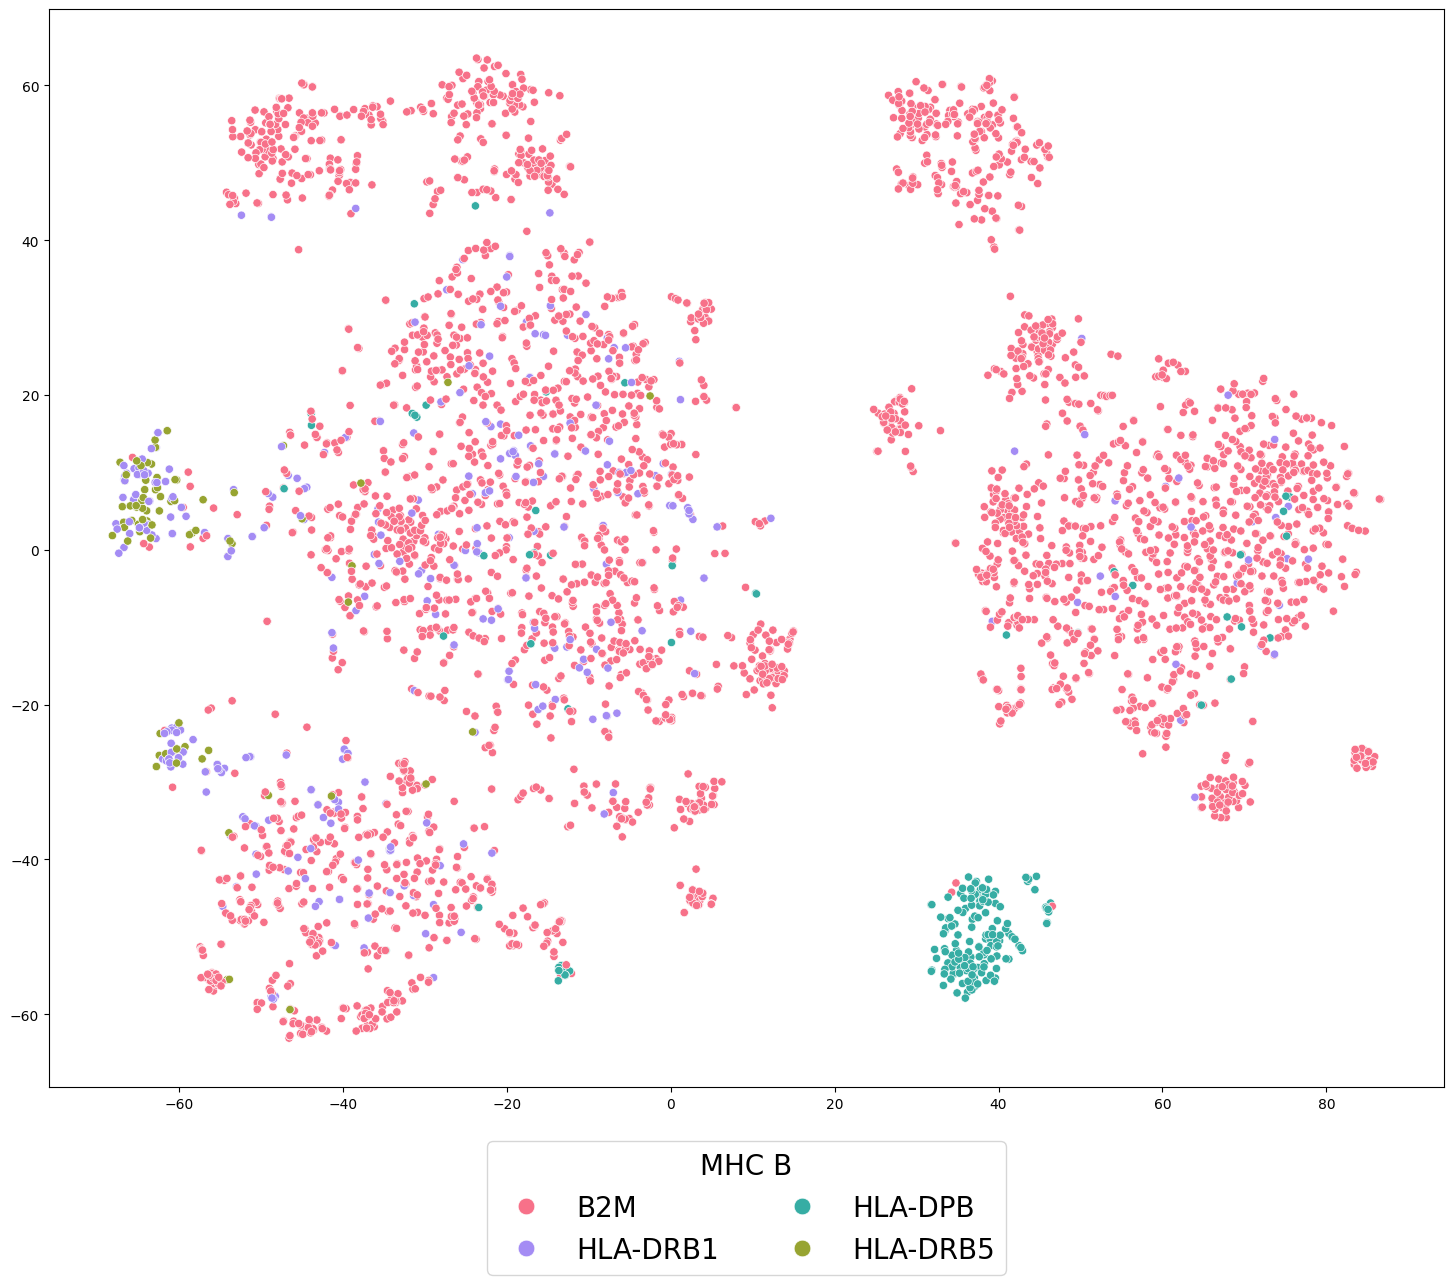

In [97]:
unique_labels = mapping_b.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping_b.keys()))
color_map = dict(zip(mapping_b.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=mhc_beta,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='MHC B',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

# plt.savefig('../imgs/epitopes/AG_species.png')

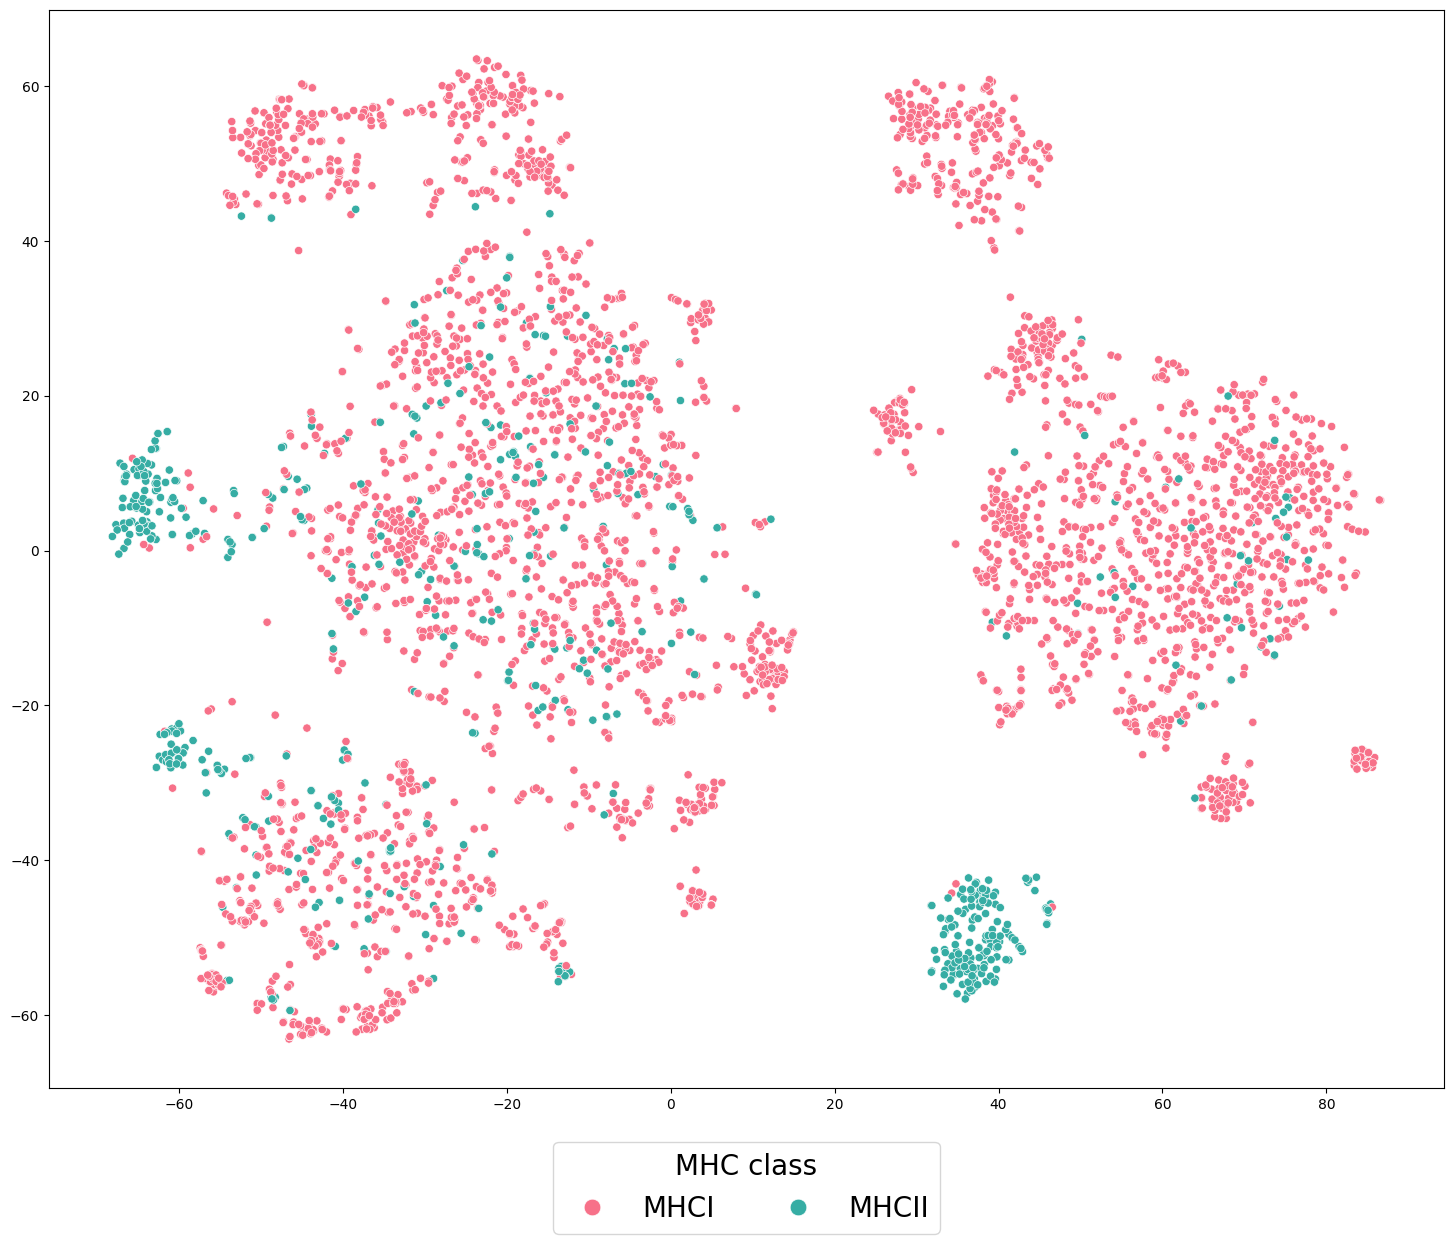

In [98]:
unique_labels = mapping_c.keys()#np.unique(le.inverse_transform(labels))
palette = sns.color_palette("husl", n_colors=len(mapping_c.keys()))
color_map = dict(zip(mapping_c.keys(), palette))

plt.figure(figsize=(18,14))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=mhc_class,
    palette=color_map,
    legend="full",
    alpha=1
)

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 1)
plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    borderaxespad=0.,
    fontsize=20,
    title='MHC class',
    title_fontsize=20,
    markerscale=2,
    ncols=2
)

# plt.savefig('../imgs/epitopes/AG_species.png')